<b><h3>Проект: Обучение с учителем: качество модели на примере компании «В один клик».</h3></b>

<b>Цель<br></b>
Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность и принести больше прибыли для компании «В один клик».
   
<b>Входные данные<br></b>
Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов.<br>

Утвержденное решение: <br>
Удерживать активность постоянных клиентов можно с помощью персонализированных предложений.<br>


Полученнпая информация с данными для работы находятся в нескольких таблицах:<br>
    1. Таблица «market_file.csv» содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.<br>
    2. Таблица «market_money.csv» содержит данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.<br>
    3. Таблица «market_time.csv» содержит данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.<br>
    4. Таблица «money.csv» содержит данныео о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.<br>

<b>План работ<br></b>
Реализовать согласованные работы:<br>
    1. Нужно промаркировать уровень финансовой активности постоянных покупателей;<br>
    2. Cобрать данные по клиентам по следующим группам;<br>
    3. Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца;<br>
    4. Выделить сегменты покупателей и разработать для них персонализированные предложения.<br>

In [1]:
# скачиваем библиотеку phik
!pip install phik -q
!pip install shap -q
! pip install scikit-learn==0.24.1 -q 

In [2]:
#строка с импортом библиокет
import os 
import pandas as pd
pd.options.mode.chained_assignment = None

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik
import shap

# загружаем класс для разбиения данных
from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_classification

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score


# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.inspection import permutation_importance


# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC





#константы
RANDOM_STATE = 42
TEST_SIZE = 0.25
count=10
encoder = LabelEncoder()
threshold = 0.9
shap.initjs()

#### Шаг 1. Загрузка данных

In [3]:
#Загрузите данные. Файлы market_file.csv, market_money.csv, market_time.csv, money.csv 
# загрузка данных из таблиц в переменные используя разделитель "," и ";"

pth1 = '/datasets/market_file.csv'
pth2 = '/datasets/market_money.csv'
pth3 = '/datasets/market_time.csv'
pth4 = '/datasets/money.csv'

if os.path.exists(pth1):
    market_file = pd.read_csv(pth1,delimiter=',',parse_dates=True)
    print(f'Файл market_file.csv успешно загружен')
else:
    print('Возникла ошибка при чтении таблиц')
    
if os.path.exists(pth2):
    market_money = pd.read_csv(pth2,delimiter=',',parse_dates=True)
    print(f'Файл market_money.csv успешно загружен')
else:
    print('Возникла ошибка при чтении таблиц')
    
if os.path.exists(pth3):
    market_time = pd.read_csv(pth3,delimiter=',')
    print(f'Файл market_time.csv успешно загружен')
else:
    print('Возникла ошибка при чтении таблиц')
    
if os.path.exists(pth4):
    money = pd.read_csv(pth4,delimiter=';',decimal = ',')
    print(f'Файл money.csv успешно загружен')
else:
    print('Возникла ошибка при чтении таблиц')
    

Файл market_file.csv успешно загружен
,Файл market_money.csv успешно загружен
,Файл market_time.csv успешно загружен
,Файл money.csv успешно загружен


#### Шаг 1.2. Проверьте, что данные в таблицах соответствуют описанию. Исследованием и объединением данных вы займётесь позже.

In [4]:
# выведем информацию о данных в таблицах

market_file.info(),
market_money.info(),
market_time.info(),
money.info()

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 1300 entries, 0 to 1299
,Data columns (total 13 columns):
, #   Column                               Non-Null Count  Dtype  
,---  ------                               --------------  -----  
, 0   id                                   1300 non-null   int64  
, 1   Покупательская активность            1300 non-null   object 
, 2   Тип сервиса                          1300 non-null   object 
, 3   Разрешить сообщать                   1300 non-null   object 
, 4   Маркет_актив_6_мес                   1300 non-null   float64
, 5   Маркет_актив_тек_мес                 1300 non-null   int64  
, 6   Длительность                         1300 non-null   int64  
, 7   Акционные_покупки                    1300 non-null   float64
, 8   Популярная_категория                 1300 non-null   object 
, 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
, 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
, 11  Ошибка_сервиса

#### Вывод шага №1.

В таблицах загруженые без ошибок, данные в таблицах предаствленны. Можно продолжать работу с ними. 

### Шаг 2. Предобработка данных

#### Проведите необходимую предобработку данных. Названия столбцов можно оставить кириллическими. Таблица market_file

In [5]:
# рассмотрим таблицу market_file
market_file.info()

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 1300 entries, 0 to 1299
,Data columns (total 13 columns):
, #   Column                               Non-Null Count  Dtype  
,---  ------                               --------------  -----  
, 0   id                                   1300 non-null   int64  
, 1   Покупательская активность            1300 non-null   object 
, 2   Тип сервиса                          1300 non-null   object 
, 3   Разрешить сообщать                   1300 non-null   object 
, 4   Маркет_актив_6_мес                   1300 non-null   float64
, 5   Маркет_актив_тек_мес                 1300 non-null   int64  
, 6   Длительность                         1300 non-null   int64  
, 7   Акционные_покупки                    1300 non-null   float64
, 8   Популярная_категория                 1300 non-null   object 
, 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
, 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
, 11  Ошибка_сервиса

In [6]:
# рассмотрим записи в таблице market_file
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


В таблице есть есть неявные дубликаты и написание столбцов требует измнения. Тип данных указан корретно.

In [7]:
# изменим написание колонок на нижний регист
market_file.rename(
    columns = {
        'Покупательская активность':'покупательская_активность',
        'Тип сервиса':'тип_сервиса',
        'Разрешить сообщать':'разрешить_сообщать',
        'Маркет_актив_6_мес':'маркет_актив_6_мес',
        'Маркет_актив_тек_мес':'маркет_актив_тек_мес',
        'Длительность':'длительность',
        'Акционные_покупки':'акционные_покупки',
        'Популярная_категория':'популярная_категория',
        'Средний_просмотр_категорий_за_визит':'средний_просмотр_категорий_за_визит',
        'Неоплаченные_продукты_штук_квартал':'неоплаченные_продукты_штук_квартал',
        'Ошибка_сервиса':'ошибка_сервиса',
        'Страниц_за_визит':'cтраниц_за_визит'
    }, 
    inplace = True
)

In [8]:
# проверим неявные дубликаты в колонках 
for i in market_file.iloc[:, 0:len(market_file)]:
    print(market_file[i].value_counts(),'\n')

215348    1
,216202    1
,216220    1
,216219    1
,216218    1
,         ..
,215779    1
,215778    1
,215777    1
,215776    1
,216647    1
,Name: id, Length: 1300, dtype: int64 
,
,Прежний уровень    802
,Снизилась          498
,Name: покупательская_активность, dtype: int64 
,
,стандарт     914
,премиум      376
,стандартт     10
,Name: тип_сервиса, dtype: int64 
,
,да     962
,нет    338
,Name: разрешить_сообщать, dtype: int64 
,
,4.1    94
,3.9    83
,4.4    82
,4.0    71
,5.5    68
,4.3    66
,4.9    60
,3.5    50
,4.6    49
,3.3    47
,4.2    43
,2.4    42
,3.8    39
,4.7    37
,3.4    33
,4.8    33
,5.1    32
,3.6    30
,5.7    28
,5.8    27
,5.3    27
,5.2    25
,5.6    25
,5.4    23
,2.6    20
,3.0    16
,3.1    16
,5.0    13
,1.7    12
,6.3    12
,6.1    12
,3.7    12
,6.6    12
,3.2    11
,0.9    11
,2.7     8
,1.5     8
,2.9     7
,4.5     6
,1.4     5
,5.9     5
,Name: маркет_актив_6_мес, dtype: int64 
,
,4    669
,5    323
,3    308
,Name: маркет_актив_тек_мес, dtype: in

In [9]:
# запишем значения в колонке 'тип_сервиса'
market_file['тип_сервиса'][market_file['тип_сервиса'] == 'стандартт'] = 'стандарт'

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> 👍</font>

In [10]:
# выполним проверку полных дубликатов
market_file[market_file.duplicated()]

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,cтраниц_за_визит


In [11]:
# узнаем количество пропусков
market_file.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
cтраниц_за_визит                       0
dtype: int64

Полных дубликатов в таблице нет. Неявные дубликаты быле устаранены. Тип название и типы данных в таблице корретны.

#### Проведите необходимую предобработку данных. Названия столбцов можно оставить кириллическими. Таблица market_money

In [12]:
# рассмотрим таблицу market_file
market_money.info()

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 3900 entries, 0 to 3899
,Data columns (total 3 columns):
, #   Column   Non-Null Count  Dtype  
,---  ------   --------------  -----  
, 0   id       3900 non-null   int64  
, 1   Период   3900 non-null   object 
, 2   Выручка  3900 non-null   float64
,dtypes: float64(1), int64(1), object(1)
,memory usage: 91.5+ KB


In [13]:
# рассмотрим записи в таблице market_file
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


выполним проверку неявных дубликатов и написания столбцов. Тип данных указан корретно.

In [14]:
# изменим написание колонок на нижний регист
market_money.rename(
    columns = {
        'Период':'период',
        'Выручка':'выручка'
    }, 
    inplace = True
)

In [15]:
# проверим неявные дубликаты в колонках 
for i in market_money.iloc[:, 0:len(market_money)]:
    print(market_money[i].value_counts(),'\n')

215349    3
,215756    3
,215792    3
,215790    3
,215788    3
,         ..
,216211    3
,216209    3
,216207    3
,216205    3
,216646    3
,Name: id, Length: 1300, dtype: int64 
,
,текущий_месяц          1300
,предыдущий_месяц       1300
,препредыдущий_месяц    1300
,Name: период, dtype: int64 
,
,4729.0    8
,5051.0    7
,4952.0    7
,0.0       6
,4974.0    6
,         ..
,4823.5    1
,5776.0    1
,5001.2    1
,4146.6    1
,4681.4    1
,Name: выручка, Length: 2776, dtype: int64 
,


In [17]:
# выполним проверку полных дубликатов
market_money[market_money.duplicated()]

,id,период,выручка


In [20]:
# узнаем количество пропусков
market_money.isna().sum()

id         0
период     0
выручка    0
dtype: int64

Полных дубликатов в таблице нет. Неявные дубликаты быле устаранены. Тип название и типы данных в таблице корретны.

#### Проведите необходимую предобработку данных. Названия столбцов можно оставить кириллическими. Таблица market_time

In [21]:
# рассмотрим таблицу market_file
market_time.info()

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 2600 entries, 0 to 2599
,Data columns (total 3 columns):
, #   Column  Non-Null Count  Dtype 
,---  ------  --------------  ----- 
, 0   id      2600 non-null   int64 
, 1   Период  2600 non-null   object
, 2   минут   2600 non-null   int64 
,dtypes: int64(2), object(1)
,memory usage: 61.1+ KB


In [22]:
# рассмотрим записи в таблице market_file
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


выполним проверку неявных дубликатов и написания столбцов. Тип данных указан корретно.

In [23]:
# изменим написание колонок на нижний регист
market_time.rename(
    columns = {
        'Период':'период'
    }, 
    inplace = True
)

In [24]:
# проверим неявные дубликаты в колонках 
for i in market_time.iloc[:, 0:len(market_time)]:
    print(market_time[i].value_counts(),'\n')

215349    2
,215756    2
,215792    2
,215790    2
,215788    2
,         ..
,216211    2
,216209    2
,216207    2
,216205    2
,216646    2
,Name: id, Length: 1300, dtype: int64 
,
,предыдцщий_месяц    1300
,текущий_месяц       1300
,Name: период, dtype: int64 
,
,14    256
,12    237
,11    221
,13    206
,10    204
,9     186
,15    174
,17    163
,16    162
,18    145
,8     141
,19    119
,20    101
,7      88
,6      59
,21     53
,22     40
,5      22
,23     14
,4       9
,Name: минут, dtype: int64 
,


In [25]:
# запишем значения в колонке 'тип_сервиса'
market_time['период'][market_time['период'] == 'предыдцщий_месяц'] = 'предыдущий_месяц'

In [26]:
# выполним проверку полных дубликатов
market_time[market_time.duplicated()]

,id,период,минут


In [27]:
# узнаем количество пропусков
market_time.isna().sum()

id        0
период    0
минут     0
dtype: int64

Полных дубликатов в таблице нет. Название было устаранено. Тип название и типы данных в таблице корретны.

#### Проведите необходимую предобработку данных. Названия столбцов можно оставить кириллическими. Таблица money

In [28]:
# рассмотрим таблицу market_time
money.info()

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 1300 entries, 0 to 1299
,Data columns (total 2 columns):
, #   Column   Non-Null Count  Dtype  
,---  ------   --------------  -----  
, 0   id       1300 non-null   int64  
, 1   Прибыль  1300 non-null   float64
,dtypes: float64(1), int64(1)
,memory usage: 20.4 KB


In [29]:
# рассмотрим записи в таблице market_time
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


выполним проверку неявных дубликатов и написания столбцов. Тип данных указан корретно.

In [30]:
# изменим написание колонок на нижний регист
money.rename(
    columns = {
        'Прибыль':'прибыль'
    }, 
    inplace = True
)

In [31]:
# проверим неявные дубликаты и ошибки в колонках 
for i in money.iloc[:, 0:len(money)]:
    print(money[i].value_counts(),'\n')

215348    1
,216202    1
,216220    1
,216219    1
,216218    1
,         ..
,215779    1
,215778    1
,215777    1
,215776    1
,216647    1
,Name: id, Length: 1300, dtype: int64 
,
,3.89    11
,4.28     9
,5.10     9
,4.18     9
,2.93     8
,        ..
,5.36     1
,2.37     1
,5.62     1
,3.01     1
,5.59     1
,Name: прибыль, Length: 400, dtype: int64 
,


In [34]:
# выполним проверку полных дубликатов
market_time[market_time.duplicated()]

,id,период,минут


In [35]:
# узнаем количество пропусков
market_time.isna().sum()

id        0
период    0
минут     0
dtype: int64

Полных дубликатов в таблице нет. Ошибок также нет. Тип название и типы данных в таблице корретны.

#### Вывод шага №2.

Пропусков в таблицах не найдено. Дубликаты удалены. Названия приведены к единому виду.
Можно продолжить иследовательский анализ с таблицей.

### Шаг 3. Исследовательский анализ данных

#### Исследовательский анализ данных из каждой таблицы market_file.

In [36]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 1300 entries, 0 to 1299
,Data columns (total 13 columns):
, #   Column                               Non-Null Count  Dtype  
,---  ------                               --------------  -----  
, 0   id                                   1300 non-null   int64  
, 1   покупательская_активность            1300 non-null   object 
, 2   тип_сервиса                          1300 non-null   object 
, 3   разрешить_сообщать                   1300 non-null   object 
, 4   маркет_актив_6_мес                   1300 non-null   float64
, 5   маркет_актив_тек_мес                 1300 non-null   int64  
, 6   длительность                         1300 non-null   int64  
, 7   акционные_покупки                    1300 non-null   float64
, 8   популярная_категория                 1300 non-null   object 
, 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
, 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
, 11  ошибка_сервиса

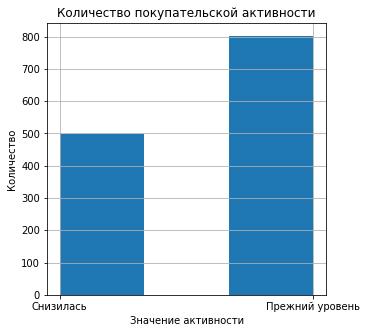

In [37]:
# построим распределенеи активности
market_file['покупательская_активность'].hist(bins=3,figsize=(5,5))
plt.title('Количество покупательской активности')
plt.xlabel('Значение активности')
plt.ylabel('Количество')
plt.show()

Прежний уровень. преобладает.

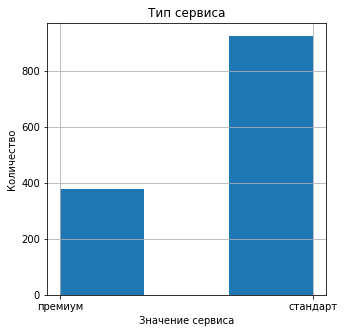

In [38]:
# построим распределенеи сервиса
market_file['тип_сервиса'].hist(bins=3,figsize=(5,5))
plt.title('Тип сервиса')
plt.xlabel('Значение сервиса')
plt.ylabel('Количество')
plt.show()

Тип Стандарт явный лидер.

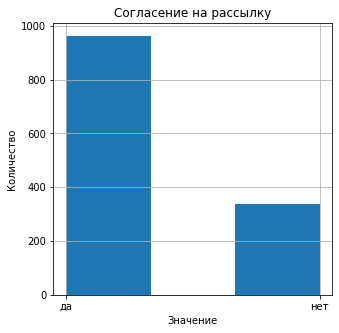

In [39]:
# построим распределенеи разрешения
market_file['разрешить_сообщать'].hist(bins=3,figsize=(5,5))
plt.title('Согласение на рассылку')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.show()

Большая часть пользователей согласна на рассылку. Это не может не радовать.

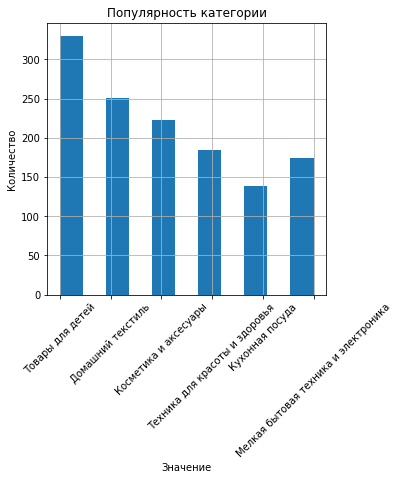

In [40]:
# построим распределение по категориям
market_file['популярная_категория'].hist(bins=11,figsize=(5,5))
plt.title('Популярность категории')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

In [41]:
market_file['популярная_категория'].value_counts()

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: популярная_категория, dtype: int64

Популярность категорий различается каскадно. Выше перечислено распределение по местам.

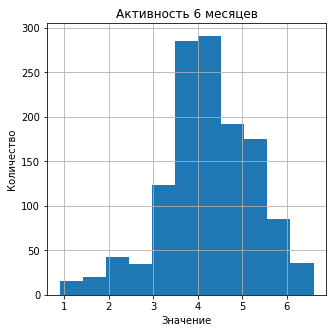

In [42]:
# построим распределение по категориям
market_file['маркет_актив_6_мес'].hist(bins=11,figsize=(5,5))
plt.title('Активность 6 месяцев')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.show()

Больше всего активности с пользвоателем было от 3 до 5 раз.

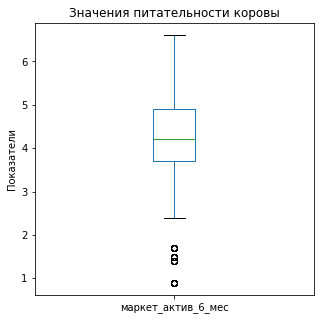

In [43]:
# построим график распределения значений
market_file['маркет_актив_6_мес'].plot(kind='box', figsize=(5, 5))
plt.title('Значения питательности коровы')
plt.ylabel('Показатели')
plt.show()

In [44]:
market_file[(market_file['маркет_актив_6_мес']<1) == True]

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,cтраниц_за_визит
81,215429,Снизилась,премиум,нет,0.9,4,690,0.24,Домашний текстиль,2,5,7,4
147,215495,Снизилась,стандарт,да,0.9,4,788,0.98,Техника для красоты и здоровья,3,3,3,3
164,215512,Снизилась,стандарт,да,0.9,3,839,0.40,Косметика и аксесуары,3,3,7,7
204,215552,Снизилась,стандарт,да,0.9,4,624,0.89,Косметика и аксесуары,1,9,5,1
205,215553,Снизилась,стандарт,да,0.9,4,360,0.33,Домашний текстиль,2,3,3,5
253,215601,Снизилась,премиум,да,0.9,4,468,0.23,Техника для красоты и здоровья,1,6,4,4
269,215617,Снизилась,стандарт,да,0.9,4,728,0.90,Домашний текстиль,2,3,2,4
353,215701,Снизилась,стандарт,да,0.9,4,212,0.95,Домашний текстиль,2,5,4,2
357,215705,Снизилась,премиум,нет,0.9,4,657,0.99,Домашний текстиль,2,4,2,5
389,215737,Снизилась,стандарт,да,0.9,4,225,0.36,Косметика и аксесуары,2,4,2,3


В таблице есть выбросы, но удалять их нельзя, потому что это число усреднено.

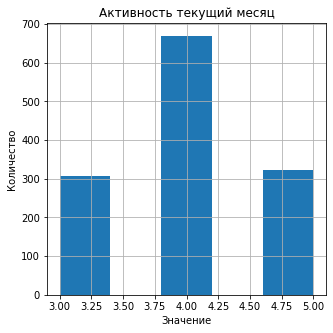

In [45]:
# построим распределение по категориям
market_file['маркет_актив_тек_мес'].hist(bins=5,figsize=(5,5))
plt.title('Активность текущий месяц')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.show()

За текущий месяц всреднем было 4 взаимодействия.

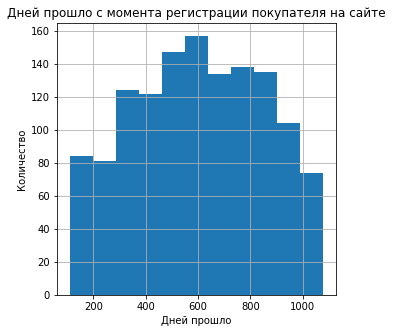

In [46]:
# построим распределение по категориям
market_file['длительность'].hist(bins=11,figsize=(5,5))
plt.title('Дней прошло с момента регистрации покупателя на сайте')
plt.xlabel('Дней прошло')
plt.ylabel('Количество')
plt.show()

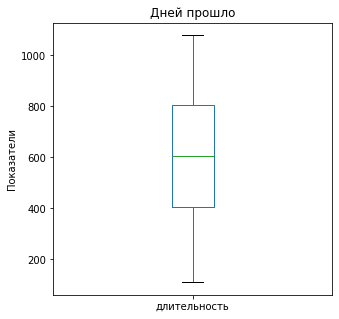

In [47]:
# построим график распределения значений
market_file['длительность'].plot(kind='box', figsize=(5, 5))
plt.title('Дней прошло')
plt.ylabel('Показатели')
plt.show()

В среднем прошло 600 дней с момента регисрации пользователей. Масимально более 1000 дней, минимум мнее 100.

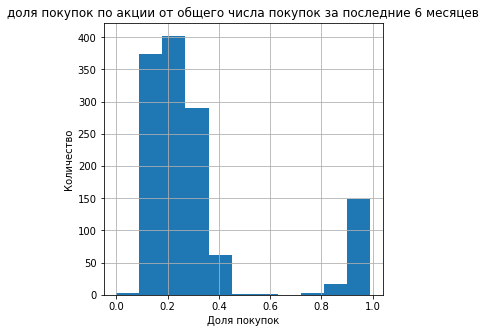

In [48]:
# построим распределение по категориям
market_file['акционные_покупки'].hist(bins=11,figsize=(5,5))
plt.title('доля покупок по акции от общего числа покупок за последние 6 месяцев')
plt.xlabel('Доля покупок')
plt.ylabel('Количество')
plt.show()

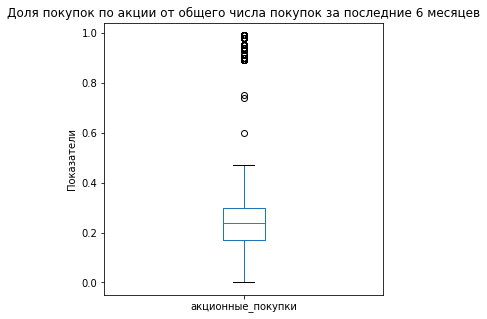

In [49]:
# построим график распределения значений
market_file['акционные_покупки'].plot(kind='box', figsize=(5, 5))
plt.title('Доля покупок по акции от общего числа покупок за последние 6 месяцев')
plt.ylabel('Показатели')
plt.show()

Средняя доля покупок по акции от общего числа покупок за последние 6 месяцев составляет чуть более 0,2. Также есть выбросы со значениями близкими к 1. Вероятно, это условия акции нашли отклик у покупателей. Удалять такое нельзя.

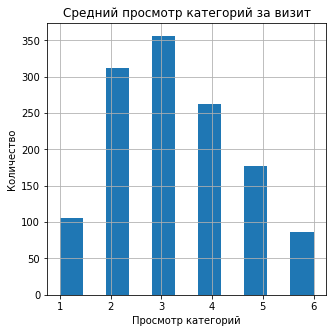

In [50]:
# построим распределение по категориям
market_file['средний_просмотр_категорий_за_визит'].hist(bins=11,figsize=(5,5))
plt.title('Средний просмотр категорий за визит')
plt.xlabel('Просмотр категорий')
plt.ylabel('Количество')
plt.show()

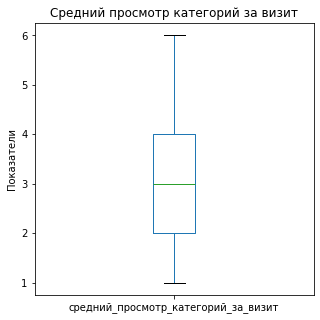

In [51]:
# построим график распределения значений
market_file['средний_просмотр_категорий_за_визит'].plot(kind='box', figsize=(5, 5))
plt.title('Средний просмотр категорий за визит')
plt.ylabel('Показатели')
plt.show()

В среднем смотрят три категории. И от 1 до 6.

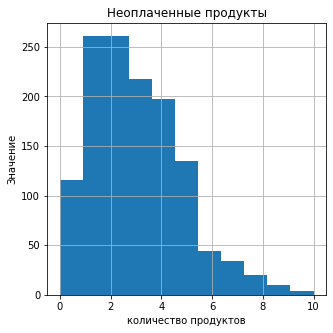

In [52]:
# построим распределение по категориям
market_file['неоплаченные_продукты_штук_квартал'].hist(bins=11,figsize=(5,5))
plt.title('Неоплаченные продукты')
plt.xlabel('количество продуктов')
plt.ylabel('Значение')
plt.show()

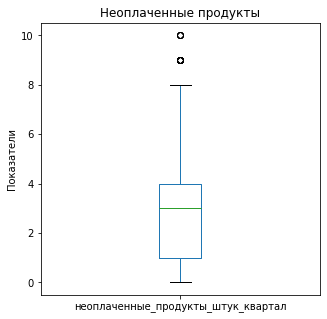

In [53]:
# построим график распределения значений
market_file['неоплаченные_продукты_штук_квартал'].plot(kind='box', figsize=(5, 5))
plt.title('Неоплаченные продукты')
plt.ylabel('Показатели')
plt.show()

In [54]:
market_file[market_file['неоплаченные_продукты_штук_квартал']>8]

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,cтраниц_за_визит
72,215420,Снизилась,стандарт,да,3.5,5,449,0.35,Домашний текстиль,1,9,2,2
73,215421,Снизилась,премиум,нет,4.0,5,523,0.94,Техника для красоты и здоровья,1,10,7,5
117,215465,Снизилась,стандарт,да,3.5,5,449,0.28,Домашний текстиль,1,9,2,2
118,215466,Снизилась,премиум,нет,2.4,5,523,0.30,Техника для красоты и здоровья,1,10,1,4
176,215524,Снизилась,стандарт,да,3.0,3,474,0.23,Техника для красоты и здоровья,1,10,4,2
186,215534,Снизилась,премиум,нет,4.0,4,419,0.93,Товары для детей,1,9,3,3
204,215552,Снизилась,стандарт,да,0.9,4,624,0.89,Косметика и аксесуары,1,9,5,1
216,215564,Снизилась,стандарт,нет,3.9,3,618,0.24,Техника для красоты и здоровья,2,10,3,5
246,215594,Снизилась,стандарт,да,4.2,4,627,0.90,Товары для детей,6,9,5,8
251,215599,Снизилась,стандарт,да,3.4,4,716,0.28,Домашний текстиль,2,9,4,6


В среднем не оплачивают три категории. Есть выбросы со значением 9 и 10, пока есть оставим и рассмотрим далее, на необходимость удаления.

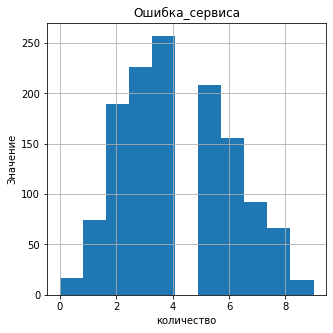

In [55]:
# построим распределение по категориям
market_file['ошибка_сервиса'].hist(bins=11,figsize=(5,5))
plt.title('Ошибка_сервиса')
plt.xlabel('количество')
plt.ylabel('Значение')
plt.show()

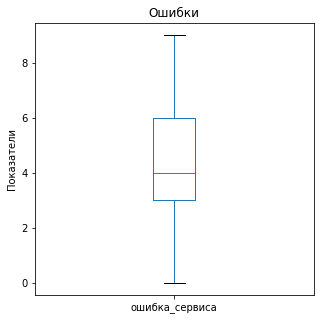

In [56]:
# построим график распределения значений
market_file['ошибка_сервиса'].plot(kind='box', figsize=(5, 5))
plt.title('Ошибки')
plt.ylabel('Показатели')
plt.show()

В среднем пользователи сталкиваются с 3 до 6  сбоев во во время посещения сайата.

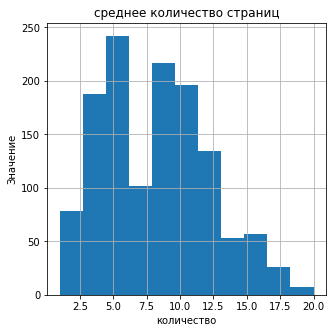

In [57]:
# построим распределение по категориям
market_file['cтраниц_за_визит'].hist(bins=11,figsize=(5,5))
plt.title('среднее количество страниц')
plt.xlabel('количество')
plt.ylabel('Значение')
plt.show()

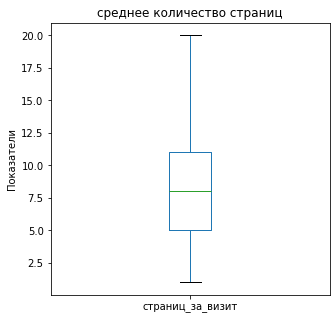

In [58]:
# строим график распределения значений
market_file['cтраниц_за_визит'].plot(kind='box', figsize=(5, 5))
plt.title('среднее количество страниц')
plt.ylabel('Показатели')
plt.show()

В среднем каждый пользователь смотрит 8 страниц на сайте за послении 3 месяца.

#### Исследовательский анализ данных из каждой таблицы market_money

In [59]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 3900 entries, 0 to 3899
,Data columns (total 3 columns):
, #   Column   Non-Null Count  Dtype  
,---  ------   --------------  -----  
, 0   id       3900 non-null   int64  
, 1   период   3900 non-null   object 
, 2   выручка  3900 non-null   float64
,dtypes: float64(1), int64(1), object(1)
,memory usage: 91.5+ KB


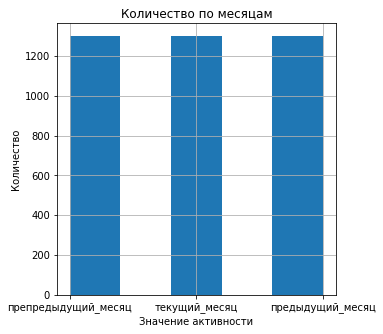

In [60]:
# построим распределенеи активности
market_money['период'].hist(bins=5,figsize=(5,5))
plt.title('Количество по месяцам')
plt.xlabel('Значение активности')
plt.ylabel('Количество')
plt.show()

Больше записей за предыдущий месяц. Более 2500.

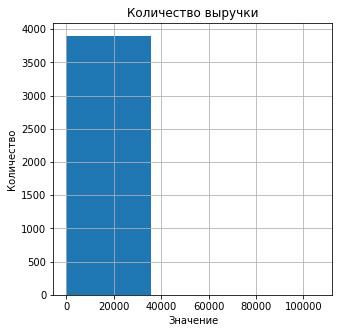

In [61]:
# построим распределенеи активности
market_money['выручка'].hist(bins=3,figsize=(5,5))
plt.title('Количество выручки')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.show()

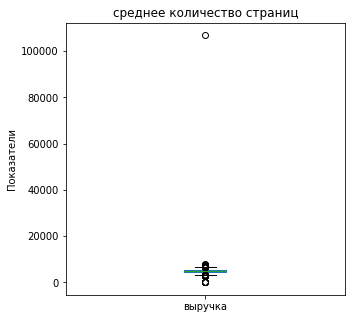

In [62]:
# построим график распределения значений
market_money['выручка'].plot(kind='box', figsize=(5, 5))
plt.title('среднее количество страниц')
plt.ylabel('Показатели')
plt.show()

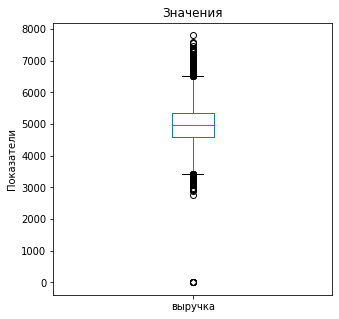

In [63]:
# построим график распределения значений без выбросов
market_money['выручка'][market_money['выручка']<100000].plot(kind='box', figsize=(5, 5))
plt.title('Значения')
plt.ylabel('Показатели')
plt.show()

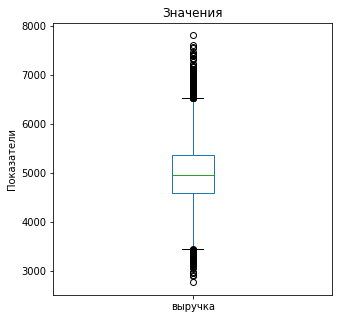

In [64]:
# построим график распределения значений без выбросов
market_money['выручка'][(market_money['выручка']<100000)&(market_money['выручка']>1000)].plot(kind='box', figsize=(5, 5))
plt.title('Значения')
plt.ylabel('Показатели')
plt.show()

In [65]:
# уточним колчиество выборосов и строк 
print(
    market_money[market_money['выручка']>100000],'\n',
    market_money[market_money['выручка']<1000]
)

        id         период   выручка
,98  215380  текущий_месяц  106862.2 
,         id               период  выручка
,0   215348  препредыдущий_месяц      0.0
,2   215348     предыдущий_месяц      0.0
,28  215357  препредыдущий_месяц      0.0
,29  215357     предыдущий_месяц      0.0
,34  215359     предыдущий_месяц      0.0
,35  215359  препредыдущий_месяц      0.0


In [66]:
# удаляем строки с выручкой мнее 1000 и более 100000
market_money = market_money[(market_money['выручка']<100000)&(market_money['выручка']>1000)]

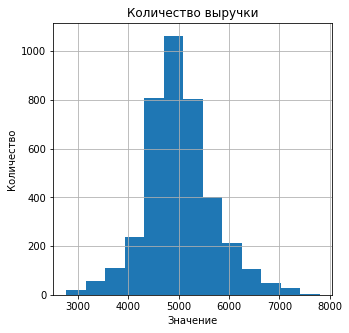

In [67]:
# построим распределенеи выручки еще раз 
market_money['выручка'].hist(bins=13,figsize=(5,5))
plt.title('Количество выручки')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.show()

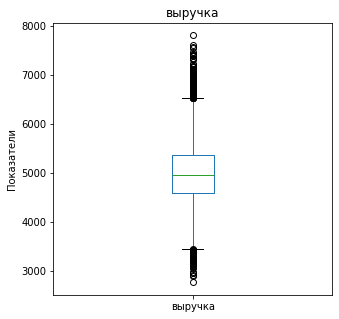

In [68]:
# построим график распределения значений
market_money['выручка'].plot(kind='box', figsize=(5, 5))
plt.title('выручка')
plt.ylabel('Показатели')
plt.show()

Теперь график выглядит номермально. С центром чуть менее 5000.

#### Исследовательский анализ данных из каждой таблицы market_time

In [69]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 2600 entries, 0 to 2599
,Data columns (total 3 columns):
, #   Column  Non-Null Count  Dtype 
,---  ------  --------------  ----- 
, 0   id      2600 non-null   int64 
, 1   период  2600 non-null   object
, 2   минут   2600 non-null   int64 
,dtypes: int64(2), object(1)
,memory usage: 61.1+ KB


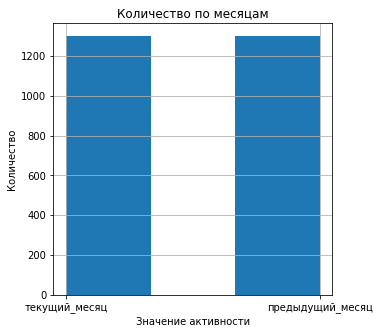

In [70]:
# построим распределенеи активности
market_time['период'].hist(bins=3,figsize=(5,5))
plt.title('Количество по месяцам')
plt.xlabel('Значение активности')
plt.ylabel('Количество')
plt.show()

Значение времени (в минутах), которое покупатель провёл на сайте в течение периодов одинаковые.

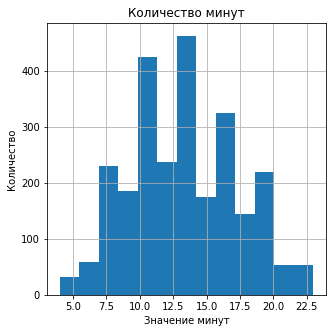

In [71]:
# построим распределенеи активности
market_time['минут'].hist(bins=13,figsize=(5,5))
plt.title('Количество минут')
plt.xlabel('Значение минут')
plt.ylabel('Количество')
plt.show()

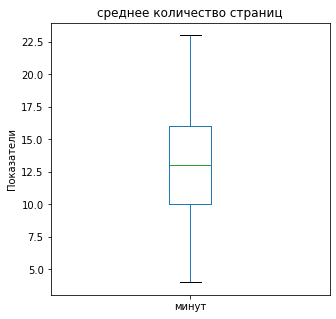

In [72]:
# построим график распределения значений
market_time['минут'].plot(kind='box', figsize=(5, 5))
plt.title('среднее количество страниц')
plt.ylabel('Показатели')
plt.show()

График рваный, со средним значением минут более 12,5.

#### Исследовательский анализ данных из каждой таблицы money

In [73]:
money.info()

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 1300 entries, 0 to 1299
,Data columns (total 2 columns):
, #   Column   Non-Null Count  Dtype  
,---  ------   --------------  -----  
, 0   id       1300 non-null   int64  
, 1   прибыль  1300 non-null   float64
,dtypes: float64(1), int64(1)
,memory usage: 20.4 KB


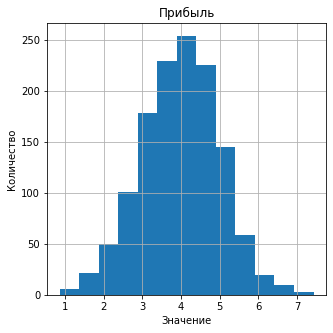

In [74]:
# построим распределенеи активности
money['прибыль'].hist(bins=13,figsize=(5,5))
plt.title('Прибыль')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.show()

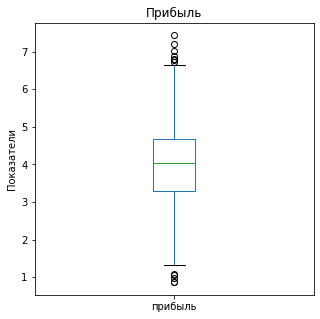

In [75]:
# построим график распределения значений
money['прибыль'].plot(kind='box', figsize=(5, 5))
plt.title('Прибыль')
plt.ylabel('Показатели')
plt.show()

В таблице срдение значение прибыли указно около 4. Также присутствуют выбросы, но это не явные, поэтому такие значения оставим.

### Шаг 4. Объединение таблиц

#### Объедините таблицы market_file.csv, market_money.csv, market_time.csv. Данные о прибыли из файла money.csv при моделировании вам не понадобятся. 

In [76]:
# проверим размерность таблиц
print(
    market_file.shape,
    market_money.shape,
    market_time.shape,
)

(1300, 13) (3893, 3) (2600, 3)


In [77]:
df_1 = market_money.pivot_table(index='id', columns='период', values='выручка', aggfunc='sum')

In [78]:
df_2 = market_time.pivot_table(index='id', columns='период', values='минут', aggfunc='sum')

In [79]:
df_1.reset_index(inplace= True , level = ['id'])
df_2.reset_index(inplace= True , level = ['id'])

In [80]:
df_1 = df_1.fillna(0)
df_2 = df_2.fillna(0)

In [81]:
print(
    df_1[df_1['предыдущий_месяц']>100000],
    df_1[df_1['предыдущий_месяц']<1000]
)

Empty DataFrame
,Columns: [id, предыдущий_месяц, препредыдущий_месяц, текущий_месяц]
,Index: [] период      id  предыдущий_месяц  препредыдущий_месяц  текущий_месяц
,0       215348               0.0                  0.0         3293.1
,9       215357               0.0                  0.0         5986.3
,11      215359               0.0                  0.0         4735.0


In [82]:
# удаляем строки с выручкой мнее 1000 и более 100000
df_1 = df_1[(df_1['предыдущий_месяц']<100000)&(df_1['предыдущий_месяц']>1000)]

In [83]:
# объеденим таблицы по ключу id
df_merge = market_file.merge(df_1, on='id')

In [84]:
# объеденим таблицы по ключу id
df_merge_1 = df_merge.merge(df_2, on='id')

In [85]:
# проверим размерность таблицы результата
df_merge_1.shape

(1297, 18)

In [86]:
# посмотрим таблицу
df_merge_1

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,cтраниц_за_визит,предыдущий_месяц_x,препредыдущий_месяц,текущий_месяц_x,предыдущий_месяц_y,текущий_месяц_y
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7
1293,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11
1294,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18
1295,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7


В таблице есть похожие названия – заменим их.

#### 4.2 Учитывайте, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделайте отдельный столбец для каждого периода.

In [87]:
# переименнуем стобцы
df_merge_1.rename(
    columns = {
        'предыдущий_месяц_x':'выручка_предыдущий_месяц',
        'препредыдущий_месяц':'выручка_препредыдущий_месяц',
        'текущий_месяц_x':'выручка_текущий_месяц',
        'предыдущий_месяц_y':'минут_предыдущий_месяц',
        'текущий_месяц_y':'минут_текущий_месяц'
    },
    inplace = True
)

### Шаг 5. Корреляционный анализ

#### Проведите корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделайте выводы о мультиколлинеарности и при необходимости устраните её.

In [88]:
# Вычисление матрицы корреляции с использованием phik
corr_matrix = df_merge_1.phik_matrix()

interval columns not set, guessing: ['id', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'cтраниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц']


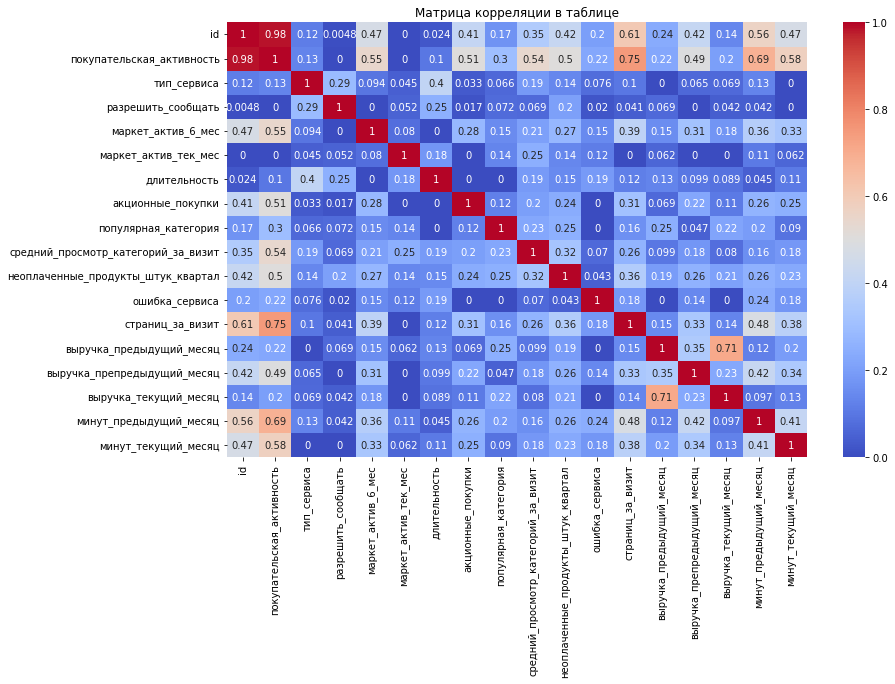

In [89]:
# строим матрицу
plt.figure(figsize=(13, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции в таблице')
plt.show()

Очень высоких корреляций (0.9 +) не видно, скорее всего, мультиколлинеарности нет.<br>
Есть подозрение на нелинейность связи покупательсткой активности с: Маркет_активн_6_мес, Средний_просмотр_категорий за визит, Неоплаченные_продукты_штук_квартал, Минут.<br>
Сильная корреляция наблюдается в связи покупательсткой активности со Страниц_за_визит (0,75). <br>
Остальные значения имеют низкую корреляцию. 

### Шаг 6. Использование пайплайнов

#### Примените все изученные модели. Для этого используйте пайплайны.
Во время подготовки данных используйте ColumnTransformer. Количественные и категориальные признаки обработайте в пайплайне раздельно. Для кодирования категориальных признаков используйте как минимум два кодировщика, для масштабирования количественных — как минимум два скейлера.

In [90]:
X = df_merge_1.drop(columns=['id','покупательская_активность'], axis=1)

In [91]:
y = df_merge_1['покупательская_активность']

In [92]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y
)

In [93]:
# создаём списки с названиями признаков
ohe_columns = [
    'разрешить_сообщать',
    'популярная_категория'
]

ord_columns = [
    'тип_сервиса'
]

num_columns = [
    'маркет_актив_6_мес',
    'маркет_актив_тек_мес',
    'длительность',
    'акционные_покупки',
    'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса',
    'cтраниц_за_визит',
    'выручка_предыдущий_месяц',
    'выручка_препредыдущий_месяц',
    'выручка_текущий_месяц',
    'минут_предыдущий_месяц',
    'минут_текущий_месяц'
]

In [94]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(
                missing_values=np.nan,
                strategy='most_frequent'
            )
        ),
        (
            'ohe',
            OneHotEncoder(
                drop='first',
                handle_unknown='ignore',
                sparse=False
            )
        )
    ]
)

In [95]:
# cоздаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    [
                        'премиум',
                        'стандарт'
                    ],
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [96]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
    ('ohe', OneHotEncoder(drop='first',handle_unknown='error'), ohe_columns),
    ('ord', OrdinalEncoder(),ord_columns),
    ('num', MinMaxScaler(),num_columns)
    ],
    remainder='passthrough'
)

In [97]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    (
        'preprocessor',data_preprocessor
    ),
    (
        'models', DecisionTreeClassifier(random_state=RANDOM_STATE)
    )
])

In [98]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(5, 100),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': [0.1, 1.0, 10.0, 100.0],
        'preprocessor__num': [StandardScaler(),MinMaxScaler(),'passthrough']  
    },

    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE,probability=True)],
        'models__kernel': ['linear', 'rbf'],
        'preprocessor__num': [StandardScaler(),MinMaxScaler(),'passthrough']
    }
]

In [99]:
# определяем поиск
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [100]:
# обучаем модель
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['разрешить_сообщать',
                                                                                'популярная_категория']),
                                                                              ('ord',
                                                                               OrdinalEncoder(),
                                                                               ['тип_сервиса']),
                                                                              ('num',
                                                        

In [101]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:
,
, Pipeline(steps=[('preprocessor',
,                 ColumnTransformer(remainder='passthrough',
,                                   transformers=[('ohe',
,                                                  OneHotEncoder(drop='first'),
,                                                  ['разрешить_сообщать',
,                                                   'популярная_категория']),
,                                                 ('ord', OrdinalEncoder(),
,                                                  ['тип_сервиса']),
,                                                 ('num', StandardScaler(),
,                                                  ['маркет_актив_6_мес',
,                                                   'маркет_актив_тек_мес',
,                                                   'длительность',
,                                                   'акционные_покупки',
,                                                   'средний_просмотр_

In [102]:
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Метрика лучшей модели на тренировочной выборке: 0.9133361576452487


In [103]:
# рассчитываем прогноз на тестовых данных
y_test_pred = randomized_search.predict_proba(X_test)

In [104]:
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:, 1])}')

Метрика ROC-AUC на тестовой выборке: 0.9128350184561066


Показатели метрики крайне успешны. Работу модели можно оценить положительно. Лучшая модель оказалась KNeighborsClassifier с парамтером n_neighbors=24.

### Шаг 7. Анализ важности признаков

#### Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP. 

In [105]:
# фиксируем лучшую модель
best_model = randomized_search.best_estimator_.named_steps['models']

In [106]:
# предобработка данных
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [107]:
ohe_feature_names = preprocessor.named_transformers_['ohe'].get_feature_names(input_features=ohe_columns)

In [108]:
# объединяем все имена признаков в один список
all_feature_names = np.concatenate([ohe_feature_names,ord_columns,num_columns])

In [109]:
# создаем DF с именами колонок
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=all_feature_names)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=all_feature_names)

In [110]:
# семпл данных 
X_train_preprocessed_smpl = shap.sample(X_train_preprocessed_df, count, random_state=RANDOM_STATE)
X_test_preprocessed_smpl = shap.sample(X_test_preprocessed_df, count, random_state=RANDOM_STATE)

In [111]:
explainer = shap.KernelExplainer(best_model.predict_proba, X_train_preprocessed_smpl)

In [112]:
shap_values = explainer.shap_values(X_test_preprocessed_smpl)

  0%|          | 0/10 [00:00<?, ?it/s]

In [113]:
shap_values.shape

(10, 20, 2)

/opt/conda/lib/python3.9/site-packages/shap/plots/_beeswarm.py:962: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
,  pl.tight_layout()


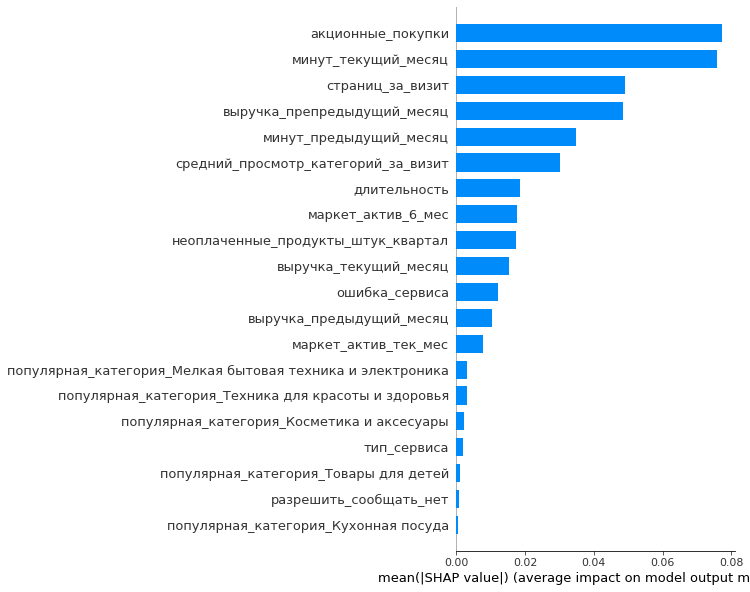

<Figure size 432x288 with 0 Axes>

In [114]:
# Построение графика с именами признаков
shap.summary_plot(shap_values[:, :, 1],X_test_preprocessed_smpl,plot_type="bar",plot_size=(5,10))
plt.tight_layout()

#### Вывод шага №7.

Самыми важными признаками оказались Аукционные покупки и Минут в текущий месяц имеют значение более 0.8. Далее оаказлись Выручка предыдущий за месяц и Страниц за визит более 0.5. Остальные каскадно распеределились после 0.4.

### Шаг 8. Сегментация покупателей

#### Выполните сегментацию покупателей. Используйте результаты моделирования и данные о прибыльности покупателей.

In [115]:
# фиксируем лучшую модель
best_model = randomized_search.best_estimator_

In [116]:
#делаем предсказания снижения покупательской активности
predictions = best_model.predict_proba(X)[:, 1]

In [117]:
df_merge_1['вероятность'] = 0

In [118]:
df_merge_1['вероятность'] = predictions

In [119]:
# создадим таблицу со снижзением покупательской активности
df = df_merge_1[df_merge_1['вероятность']<0.9]

In [120]:
# добавим таблицу money
df = df.merge(money, on='id')

In [125]:
# разделим сегменты
segment_1 = df[(df['вероятность']>=0.7)]
segment_2 = df[(df['вероятность']<0.7)]

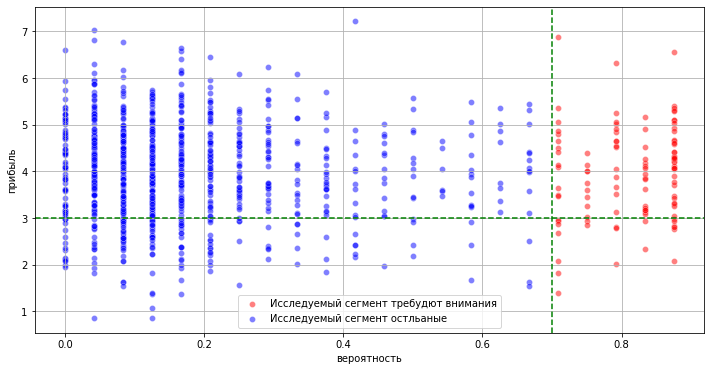

In [126]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=segment_1, 
    x='вероятность',
    y='прибыль',
    label='Исследуемый сегмент требудют внимания',
    color='red',
    alpha = 0.5
)
sns.scatterplot(
    data=segment_2, 
    x='вероятность',
    y='прибыль',
    label='Исследуемый сегмент остльаные',
    color='blue',
    alpha = 0.5
)

plt.legend()
plt.axvline(x=0.7, color='green', linestyle= '--')
plt.axhline(y=3, color='green', linestyle= '--')
plt.grid(which='major')
plt.show()

In [127]:
# разделим сегменты
segment_1 = df[(df['вероятность']>=0.7)&(df['прибыль']>4)]
segment_2 = df[(df['вероятность']<0.7)]

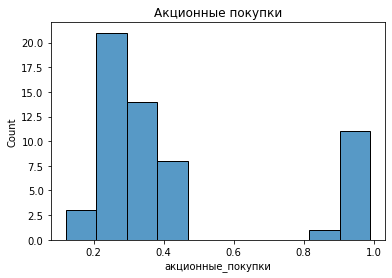

In [128]:
#строим графики по факторам

sns.histplot((segment_1['акционные_покупки']), bins=10)
plt.title('Акционные покупки')
plt.show()

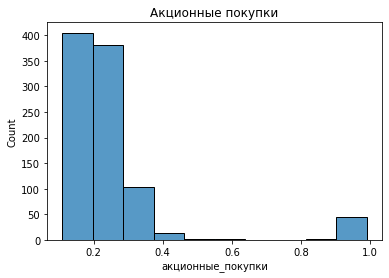

In [129]:
#строим графики по факторам

sns.histplot((segment_2['акционные_покупки']), bins=10)
plt.title('Акционные покупки')
plt.show()

На графике двух сегментов видно, что исследуемый сегмент имеет меньше количестов и при это часть значней почти со стопроцентной вероятностью снижения дохода. Это фактор, который требует внимания.

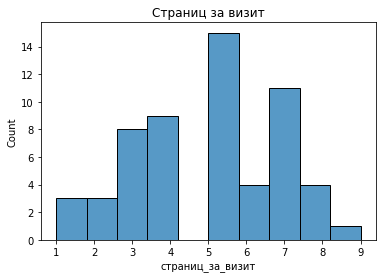

In [130]:
#строим графики по факторам

sns.histplot((segment_1['cтраниц_за_визит']), bins=10)
plt.title('Страниц за визит')
plt.show()

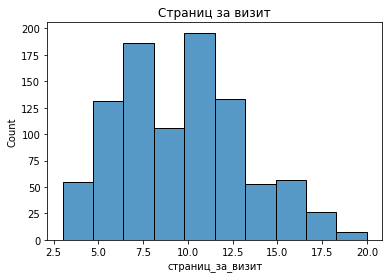

In [131]:
#строим графики по факторам

sns.histplot((segment_2['cтраниц_за_визит']), bins=10)
plt.title('Страниц за визит')
plt.show()

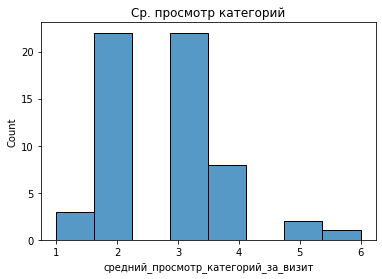

In [132]:
#строим графики по факторам

sns.histplot((segment_1['средний_просмотр_категорий_за_визит']), bins=8)
plt.title('Ср. просмотр категорий')
plt.show()

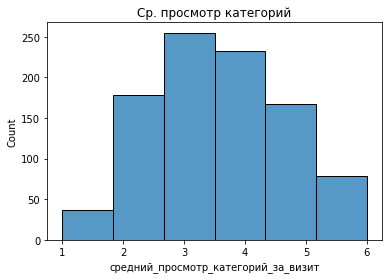

In [133]:
#строим графики по факторам

sns.histplot((segment_2['средний_просмотр_категорий_за_визит']), bins=6)
plt.title('Ср. просмотр категорий')
plt.show()

В исследуемой группе среднее количество посещаемых категорий за визит составляет 2-3. Значения от 4 до 6 имеют значительно меньше уровень. Стоит обратить вниамние на этот показатель для увеличения прибыли.

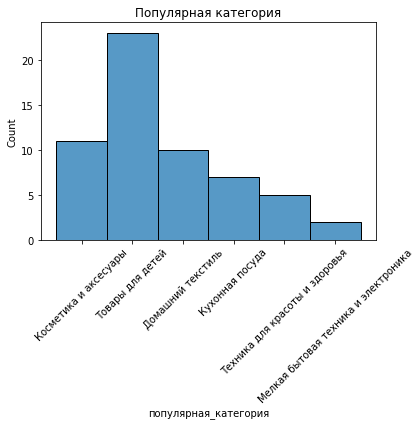

In [134]:
#строим графики по факторам

sns.histplot((segment_1['популярная_категория']), bins=6)
plt.title('Популярная категория')
plt.xticks(rotation=45)
plt.show()

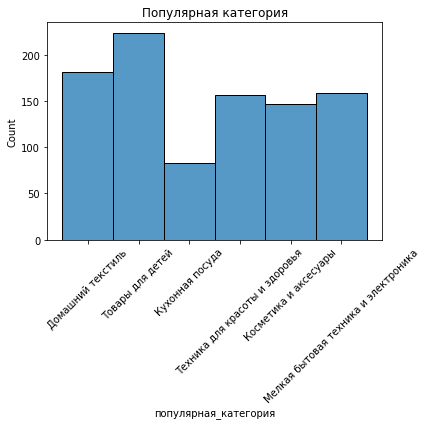

In [135]:
#строим графики по факторам

sns.histplot((segment_2['популярная_категория']), bins=6)
plt.title('Популярная категория')
plt.xticks(rotation=45)
plt.show()

В выборной категории только одна категория имеет хороший показетель, а остальные сильно меньше. В отличе от сравнимого сегмента, где почти все категории имеют +- равное значние. 
Для увеличения прибыли в исследуемом сегменте необходимо поднимать знаяимость остальных категорий.

Наиболее высокую прибольность имют пользователи со значением более 4.717500 и таких 605 штук.

Для увеличения продаж в сегменте "Группа клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью" можно увеличить количество акцций, так как сейча график выглядит неравномерным. А значит среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев не превышает 0.4. Увеличение этого числа модет поспособствовать прибольности группы.

Также стоит увеличить количество акций для категорий отличных от Косметика, чтобы показатели остальных были не такими низкими. Это напрямую повлияет на прибыль сегмента.

Также увеличение акций для сегмента повлияет на график просмотра категорий за визит, что также повлияет на количестов прибыли. Ведь пользователи будут больше времени проводить в приложении.


### Шаг 9. Общий вывод

<b>В начале проекта были поставлены следующие задачи:<br></b>

    1. Построить модель для предсказания снижения покупательской активноски.<br>
    2. Выделить сегменты покупателей и разработать для них персонализированные предложения.

<b>Были предоставлены следующие таблицы с данными:<br></b>

    1. market_file.csv – Таблица с данными о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
    2. market_money.csv. – Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
    3. market_time.csv. – Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
    4. money.csv. – Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
    
    
<b>Для посика лучшей модели были проделаны следующие шаги:<br></b>

    Обработаны пропуски и дубликаты в таблицах. Исследованы данные в них и проверены на выбросы и аномалии. Проведен корреляционный анализ. Постоена модель с подбором лучшего результата обучения. Лучшая модель оказалась KNeighborsClassifier со значением соседей 24. На основе выбранной модели был построен график с параметрами, которые сильнее всего влияют предсказание. На основе этих параметров был сделан вывод, что при снижении покупательской активности стоит акцентировать внимание пользователей и добавлять количество акционных товаров.